# Libraries

In [308]:
import numpy as np
import pandas as pd 
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.0, style="dark")
import warnings 
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
# from tflearn.data_utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import confusion_matrix as confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# Data Manipulation

In [309]:
## Make 1 or True  if you run colab
## Other wise 0 or False
##if you run in  colab

colab = 0
if colab ==True:
  data_dir='/content/drive/MyDrive/PIMA Journal/diabetes.csv'
  from google.colab import drive
  drive.mount('/content/drive')
else:
  
  data_dir='Diabetes_processed.csv'


In [310]:
data = pd.read_csv(data_dir)
all_clf_res = {
               'BloodPressure':[],
               'Glucose':[]
}

In [311]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,171.474227,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,113.606695,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.059259,171.474227,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,5.0,116.0,74.0,27.094512,113.606695,25.6,0.201,30.0,0


In [312]:
def swap_col(target_):
  swap_data = copy.deepcopy(data)
  swap_data[target_] = data.Outcome
  swap_data.Outcome = data[target_]
  swap_data.rename(columns = {'Outcome':target_, target_: 'Diabetic'}, inplace = True)
  #swap_data.Diabetic.replace({1:'Yes', 0:'No'} , inplace = True)
  return swap_data

In [313]:
data_BP = swap_col('BloodPressure')

#data_ST = swap_col('SkinThickness')
#data_Ins = swap_col('Insulin')
#data_BMI = swap_col('BMI')
#data_DPF = swap_col('DiabetesPedigreeFunction')
#data_Age = swap_col('Age')
#data_Pregnancies = swap_col('Pregnancies')

In [314]:
data_BP.head()

,Pregnancies,Glucose,Diabetic,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BloodPressure
0,6.0,148.0,1,35.000000,171.474227,33.6,0.627,50.0,72.0
1,1.0,85.0,0,29.000000,113.606695,26.6,0.351,31.0,66.0
2,8.0,183.0,1,32.059259,171.474227,23.3,0.672,32.0,64.0
3,1.0,89.0,0,23.000000,94.000000,28.1,0.167,21.0,66.0
4,5.0,116.0,0,27.094512,113.606695,25.6,0.201,30.0,74.0


In [315]:
knn_res = pd.DataFrame()
random_initializer=100            #random initializer
n_dots=50

# Utility Functions


In [316]:
def metrics (y_true, y_pred, probas_, tprs, mean_fpr):
  '''
  Parameters :
  Input - 
  y_true - true  value of input data    
  y_pred- predicted  value of input data  
  probas_- probability/confidence of predicted output

  return -True Negative(tn),False Positive(fp),False Negative(fn)
  True positive(tp),AUC(roc_auc),False Positive Rate(fpr),
  True positive rate(tpr)

  '''


  points=n_dots*'-'
  print(points)
#    print("Best parameters set found on development set:")
#    print(clf.best_params_)
  fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  #  aucs.append(roc_auc)
  print("Detailed classification report for current fold:")
  print()
  print(classification_report(y_true, y_pred))
  print()
  print("Area Under ROC (AUC): {}".format(roc_auc))
  print()
  print('Confusion Matrix for current fold: ')
  print(confusion_matrix(y_true, y_pred))
  print()
  print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
  print()
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  return  tn, fp, fn, tp, roc_auc, fpr, tpr

#*******************************************************************************#

def plot_Current_ROC(fpr,tpr,iterator,roc_auc):
  
  '''
  Parameters :
  Input - 
  fpr - False positive rate
  tpr - True positive rate
  roc_auc -auc values of roc curve

  Output - 
  Visalization of current roc curve

  '''
  plt.plot(fpr,
          
          tpr,
          # Color[iterator],
          alpha=0.35,
          # label='macro-average ROC (AUC = {0:0.3f})'.format(roc_auc)
          # +FOLD[iterator],
          linewidth=1)
  

#*******************************************************************************#
   
def average_ROC(mean_fpr,tprs,aucs,TP,TN,FP,FN):

  '''
  Parameters :
  mean_fpr - Mean False positive rate
  tprs -values of true positive rate
  aucs  - values of auc
  TP    - True positive 
  TN    - True Negative
  FP    - False Positiv
  FN    - False Negative

  Output - 
  Visalization of TPR vs FPR plot
  '''
  sen = (np.sum(TP))/(np.sum(TP)+np.sum(FN))
  spe = (np.sum(TN))/(np.sum(TN)+np.sum(FP))

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  # mean_auc = auc(mean_fpr, mean_tpr)
  mean_auc = np.mean(aucs)
  std_auc = np.std(aucs)
  # plt.figure(figsize=(8, 5))
  # plt.grid(True)
  ax = plt.axes()
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)
  # Setting the background color
  ax.set_facecolor("white")
  
  ax.spines['bottom'].set_color('#000000')
  ax.spines['top'].set_color('#000000') 
  ax.spines['right'].set_color('#000000')
  ax.spines['left'].set_color('#000000')

  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Avg. ROC (AUC (avg $\pm$ std) = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)
  
  plt.scatter((1-spe), sen, s=80, c='r', marker='x',)
  plt.scatter(0, sen, s=80, c='r', marker='x',)
  plt.scatter((1-spe),0, s=80, c='r', marker='x',)
  plt.axhline(y=sen, color='r', linestyle='--')
  plt.axvline(x=(1-spe), color='r', linestyle='--')
  plt.text((1-spe), 0.02, "FPR={:0.3f}".format((1-spe)))
  plt.text(0.009, sen+0.05, "TPR={:0.3f}".format(sen))

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='darkgray', alpha=0.5,
                  label=r'$\pm$ 1 Standard deviation')

  plt.xticks(np.arange(0.0, 1.01, step=0.1))
  plt.yticks(np.arange(0.0, 1.01, step=0.1))
  left=0.0
  right=1.0
  plt.xlim(left, right)
  plt.ylim(left, right)
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")
  # plt.grid(True)
  plt.show()

#*******************************************************************************#

def average_performance(aucs,Accuracy,TP,TN,FP,FN, target_col): 

  '''
  Parameters :
  Input - 
  Accuracy - value of accuracy
  TP  - True Positive
  TN  - True Negative
  FP  - False Positive
  FN  - False Negative


  Output - 
  It prints the average accuarcy,confusion matrix
  '''

  print()
  n_dotsav=(n_dots-len('Average'))//2
    
  print('-'*n_dotsav+'Average'+'-'*n_dotsav)
  print("AUC (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(aucs),np.std(aucs)))
  print("Accuracy (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(Accuracy),np.std(Accuracy)))
  cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN)), int(np.mean(TN))]]
  print ('Avg. CM is '+str(cm))
  cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
  print ('Total for all folds CM is '+str(cm))
  re_auc=str(round(np.mean(aucs), 3))+'+/-'+str(round(np.std(aucs),3))
  re_accuracy=str(round(np.mean(Accuracy), 3))+'+/-'+str(round(np.std(Accuracy),3))
  all_clf_res[target_col].append(re_auc)

def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):
 
    clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='f1',
                    n_jobs=-1)
    clf.fit(X_Train, Y_Train)
    return clf

#*******************************************************************************#
    
def feature_Selector(data, algo, n_feature):
 
    if algo=='PCA':                                                   #for pca algorithm
        X_Data= data.iloc[:,:8].values
        pca = PCA(n_components=n_feature)                             #number of feature
        X_Data = pca.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
 
    if algo == 'ICA':
        X_Data= data.iloc[:,:8].values
        ICA = FastICA(n_components=n_feature, random_state=12) 
        X_Data = ICA.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
    
    if algo =='corr':                                                   #for ica algorithm
        if n_feature ==4:
            data = data[['F2','F5','F4','F6','Outcome']]                #for 4 feature
            return data.iloc[:,:4].values, data.iloc[:,4:].values
        if n_feature ==6:
            data = data[['F1','F2','F4','F5','F6','F8','Outcome']]       #for 6 feature
            return data.iloc[:,:6].values, data.iloc[:,6:].values
        
    if algo == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values            #if feature selection is off all features are counted

#*******************************************************************************#

In [317]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_initializer)

# **Classifiers**

## KNN Classifier

In [318]:
def clf_KNN(X_Data, Y_Lavel, target_col):

    Accuracy = []                                                                # for store the value of accuracy 
    FP = []                                                                      # for store False Positive 
    TN = []                                                                      # for True Negative
    FN = []                                                                      # for False Negative
    TP = []                                                                      # for True Positive
    tprs = []                                                                    # for true positive rates
    aucs_kNN = []                                                                # for store the values of auc
    iterator=0
    mean_fpr = np.linspace(0, 1, 100)
    fig = plt.figure(figsize=(8, 5))

    for train_index, test_index in kf.split(X_Data,Y_Lavel):                     # split in train and test
        #   print("TRAIN:", train_index, "TEST:", test_index)
        X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
        Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test data and label

        ###########################################
        # define the hyper parameters of Knn
        n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
        leaf_size = [5,10,15,20,25,30,35,40,45,50]
        Distance = [1,2]
        ############################################


        tuned_parameters = [ {'n_neighbors': n_neighbors,                         #define parameters with different algorithm
                            'algorithm' : ['brute'],
                            'p':Distance},

                            {'n_neighbors': n_neighbors, 
                            'algorithm' : ['ball_tree'],
                            'leaf_size' : leaf_size,
                            'p':Distance},

                            {'n_neighbors': n_neighbors, 
                            'algorithm' : ['kd_tree'],
                            'leaf_size' : leaf_size,
                            'p':Distance}]

        clf = creat_Model (classifier = KNeighborsClassifier(),                     #create the model 
                          X_Train = X_Train,
                          Y_Train = Y_Train,
                          tuned_parameters = tuned_parameters,
                          verbose=0)

        tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,               #get the values of  model evaluation 
                                                    y_pred = clf.predict(X_Test),
                                                    probas_ = clf.predict_proba(X_Test), 
                                                    tprs = tprs,
                                                    mean_fpr = mean_fpr)
        tprs.append(interp(mean_fpr, fpr, tpr))                                     
        tprs[-1][0] = 0.0
        aucs_kNN.append(roc_auc)
        plot_Current_ROC (fpr,tpr,iterator,roc_auc)                                 #plot the roc of current fold
        iterator += 1
        plot_confusion_matrix(clf, X_Test, Y_Test)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        TP.append(tp)
        Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    average_ROC(mean_fpr,tprs,aucs_kNN,TP,TN,FP,FN)                                 #plot average roc curve
    average_performance(aucs_kNN,Accuracy,TP,TN,FP,FN, target_col)                  #print the average performance of the model   
    knn_res[target_col+'_KNN'] = Accuracy

## Decision Tree

In [319]:
def clf_DT(X_Data, Y_Lavel, target_col):

  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_Tree = []                                                               # for store the values of auc of tree model
  iterator=0
  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))

  for train_index, test_index in kf.split(X_Data,Y_Lavel):
      #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

                                                                              # define the decision tree parameters 

      tuned_parameters = {'criterion': ['gini','entropy'],
                        'splitter': ['best'],
                        'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                        'min_samples_leaf': [1,2,3,4,5] }

      clf = creat_Model (classifier = DecisionTreeClassifier( random_state=random_initializer),
                        X_Train = X_Train,                                    # create the model using DecisionTree Classifier 
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)

      tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,           #get the evaluation parameters of model
                                                  y_pred = clf.predict(X_Test),
                                                  probas_ = clf.predict_proba(X_Test),
                                                  tprs = tprs, 
                                                  mean_fpr = mean_fpr)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      aucs_Tree.append(roc_auc)                                                # plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  average_ROC(mean_fpr,tprs,aucs_Tree,TP,TN,FP,FN)                             #plot average roc curve
  average_performance(aucs_Tree,Accuracy,TP,TN,FP,FN, target_col)                          #print the average performance of the model

## Random Forest

In [320]:
def clf_RF(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_Forest = []                                                             # for store the values of auc of Random Forest model
  iterator=0
  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))

  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     #split dataset into train /test
  #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                # data and label of train dataset
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              # data and label of test dataset

      # parameters of Random Forest model
      tuned_parameters = {'criterion': ['gini','entropy']}

      clf = creat_Model (classifier = RandomForestClassifier( random_state=random_initializer),
                        X_Train = X_Train,                                      # create a model using random forest classifier
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)

      tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,              #evaluation parameters of random forest model
                                                  y_pred = clf.predict(X_Test),
                                                  probas_ = clf.predict_proba(X_Test),
                                                  tprs = tprs, 
                                                  mean_fpr = mean_fpr)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      aucs_Forest.append(roc_auc)
      plot_Current_ROC (fpr,tpr,iterator,roc_auc)                               #plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  average_ROC(mean_fpr,tprs,aucs_Forest,TP,TN,FP,FN)                            #plot average roc curve
  average_performance(aucs_Forest,Accuracy,TP,TN,FP,FN, target_col)                         #print the average performance of the model

## AdaBoost

In [321]:
def clf_AB(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_aBoost = []                                                             # for store the values of auc of Adaboost model
  iterator=0

  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))


  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     #split into train and test 
      #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #data and label

      #####################################################
      # define the parameters of adaboost algorithm
      #####################################################
      tuned_parameters = { 'algorithm': ['SAMME','SAMME.R'],
                        'learning_rate':[0.1,0.5,1.0],
                        'n_estimators': [10,50,100,200]}

      
      clf = creat_Model (classifier = AdaBoostClassifier( random_state=random_initializer),
                        X_Train = X_Train,                                      # create a model using  AdaBoost Classifier
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,             # model evaluation parametrs
                                                  y_pred = clf.predict(X_Test),
                                                  probas_ = clf.predict_proba(X_Test),
                                                  tprs = tprs, 
                                                  mean_fpr = mean_fpr)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      aucs_aBoost.append(roc_auc)
      plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              #plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                           #plot average roc curve
  average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN, target_col)                        #print the average performance of the model

## Naive Bayes

In [322]:
def clf_NB(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_NB = []                                                                 # for store the values of auc of  model
  iterator=0

  mean_fpr = np.linspace(0, 1, 100) 
  fig = plt.figure(figsize=(8, 5))


  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     #split into train and test
  #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test  data and label


      #############################################
      # define parameters of Naive Bayes model 
      ############################################
      var_smoothing = [1e-01,
                      1e-02,
                      1e-03,
                      1e-04,
                      1e-05,
                      1e-06,
                      1e-07,
                      1e-08,
                      1e-09,
                      1e-10,
                      1e-11,
                      1e-12]

      tuned_parameters = [{'var_smoothing': var_smoothing}]

      #############################################################
      clf = creat_Model (classifier = GaussianNB(),                             # create model using Naive Bias
                        X_Train = X_Train,
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,             # model evaluation parameters
                                                  y_pred = clf.predict(X_Test),
                                                  probas_ = clf.predict_proba(X_Test),
                                                  tprs = tprs, 
                                                  mean_fpr = mean_fpr)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      aucs_NB.append(roc_auc)
      plot_Current_ROC (fpr,tpr,iterator,roc_auc)                               #plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  average_ROC(mean_fpr,tprs,aucs_NB,TP,TN,FP,FN)                               #plot average roc curve
  average_performance(aucs_NB,Accuracy,TP,TN,FP,FN, target_col)                            #print the average performance of the model

## XGBoost

In [323]:
def clf_XGB(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_xboost = []                                                                # for store the values of auc
  sn = []                                                                      # for sensitivity 
  sp = []                                                                      # for specificity
  pr = []                                                                      # for precision
  FOR = []                                                                     # for False omission rate 
  DOR = []                                                                     # for Diagnostic odds ratio (DOR)
  iterator=0
  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))


  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     # split into train and test
  #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test data and label

      #####################################
      ## define the parameters 
      ######################################
      tuned_parameters = {
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.5, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
          }

      clf = creat_Model (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error', random_state=random_initializer),
                        X_Train = X_Train,                                        # create model using XGB classifier 
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,               #evaluate the model parameters
                                                  y_pred = clf.predict(X_Test),
                                                  probas_ = clf.predict_proba(X_Test),
                                                  tprs = tprs, 
                                                  mean_fpr = mean_fpr)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      aucs_xboost.append(roc_auc)
      plot_Current_ROC(fpr,tpr,iterator,roc_auc)                                  #plot the roc of current fold 
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
      sn.append(tp/(tp+fn))
      sp.append(tn/(fp+tn))
      pr.append(tp/(tp+fp))
      FOR.append(fn/(tn+fn))
      DOR.append((tp*tn)/(fp*fn))

  average_ROC(mean_fpr,tprs,aucs_xboost,TP,TN,FP,FN)                              #plot average roc curve
  average_performance(aucs_xboost,Accuracy,TP,TN,FP,FN, target_col)               #print the average performance of the model

  #####################################################################
  #    print the sensitivity,specificity,precision,for,dor of model
  #####################################################################
  print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
  print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
  print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
  print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
  print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

# With BloodPressure as Target

In [324]:
data_BP.head(), data_BP.shape

(   Pregnancies  Glucose  ...   Age  BloodPressure
 0          6.0    148.0  ...  50.0           72.0
 1          1.0     85.0  ...  31.0           66.0
 2          8.0    183.0  ...  32.0           64.0
 3          1.0     89.0  ...  21.0           66.0
 4          5.0    116.0  ...  30.0           74.0
 
 [5 rows x 9 columns], (636, 9))

In [325]:
def categorize_BP(data_BP):
    
    BP = "BloodPressure"
    try:
        norm_i = data_BP.loc[(data_BP[BP] <= 80)] #diastolic less than 80 is normal
        #elevated_i = data_BP.loc[(data_BP[BP] > 80) & (data_BP[BP] < 90)] #diastolic between 80 and 89 is elevated
        high_i =  data_BP.loc[data_BP[BP] > 80] #diastolic greater than 80 is high
 
        data_BP[BP][norm_i.index] = 0
        #data_BP[BP][elevated_i.index] = 2
        data_BP[BP][high_i.index] = 1
     
    except:
        pass
    
    return data_BP

In [326]:
data_BP = categorize_BP(data_BP)

In [327]:
#Augmentation
smote = SMOTE()
X = np.array(data_BP.iloc[:,0:8])
y = np.array(data_BP.iloc[:,8])
X, y = smote.fit_resample(X, y)
data_BP = pd.DataFrame(X)
data_BP['BloodPressure'] = y
data_BP

,0,1,2,3,4,5,6,7,BloodPressure
0,6.000000,148.000000,1.0,35.000000,171.474227,33.600000,0.627000,50.000000,0.0
1,1.000000,85.000000,0.0,29.000000,113.606695,26.600000,0.351000,31.000000,0.0
2,8.000000,183.000000,1.0,32.059259,171.474227,23.300000,0.672000,32.000000,0.0
3,1.000000,89.000000,0.0,23.000000,94.000000,28.100000,0.167000,21.000000,0.0
4,5.000000,116.000000,0.0,27.094512,113.606695,25.600000,0.201000,30.000000,0.0
...,...,...,...,...,...,...,...,...,...
1003,4.000000,143.258734,1.0,32.021963,171.474227,40.538483,0.587728,31.440502,1.0
1004,8.000000,185.656501,1.0,35.198868,225.108473,34.556045,0.418336,37.108473,1.0
1005,8.551002,159.343503,0.0,29.728184,113.606695,28.182999,0.209048,49.653005,1.0
1006,4.154262,136.794317,0.0,27.094512,113.606695,31.662786,0.274831,30.359945,1.0


In [328]:
data_BP.BloodPressure.value_counts()

1.0    504
0.0    504
Name: BloodPressure, dtype: int64

In [329]:
data_BP.columns = ['F' + str(i) for i in range(1,9)]+['Outcome'] #Renaming

In [330]:
X_Data,Y_Lavel = feature_Selector(data_BP, algo='None', n_feature=8)  

In [331]:
np.unique(Y_Lavel,return_counts = True)

(array([0., 1.]), array([504, 504]))

#### Analyzing **KNN**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83       101
         1.0       0.80      0.92      0.86       101

    accuracy                           0.85       202
   macro avg       0.85      0.85      0.85       202
weighted avg       0.85      0.85      0.85       202


Area Under ROC (AUC): 0.8465346534653466

Confusion Matrix for current fold: 
[[78 23]
 [ 8 93]]

Accuracy for Current Fold: 0.8465346534653465

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.87      0.67      0.76       101
         1.0       0.73      0.90      0.81       101

    accuracy                           0.79       202
   macro avg       0.80      0.79      0.78       202
weighted avg       0.80      0.79      0.78       202

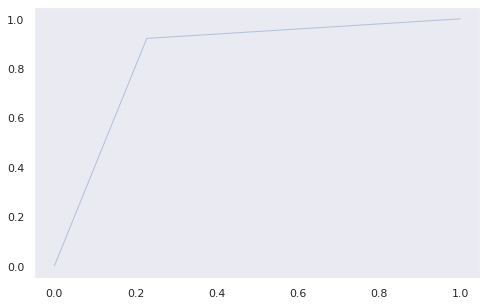

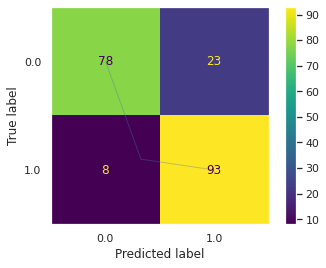

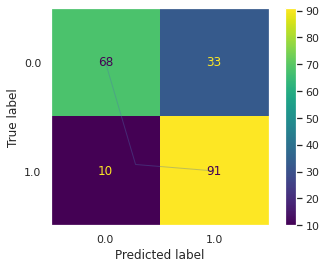

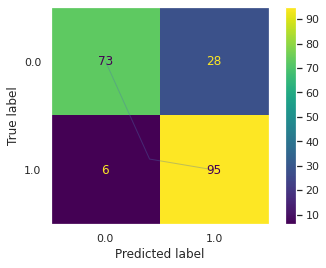

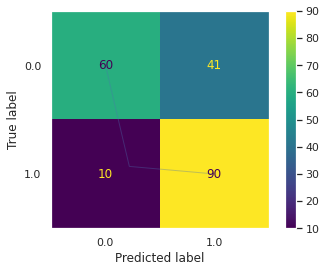

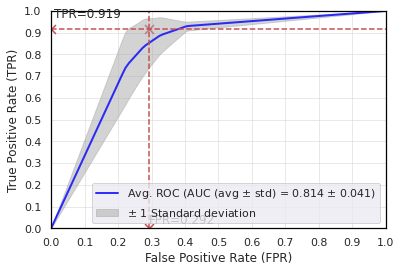


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.814 +/- 0.041
Accuracy (Avg. +/- Std.) is  0.813 +/- 0.041
Avg. CM is [[92, 29], [8, 71]]
Total for all folds CM is [[463, 147], [41, 357]]


In [332]:
clf_KNN(X_Data, Y_Lavel, 'BloodPressure')

#### Analyzing **Decision Trees**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69       101
         1.0       0.69      0.80      0.74       101

    accuracy                           0.72       202
   macro avg       0.72      0.72      0.72       202
weighted avg       0.72      0.72      0.72       202


Area Under ROC (AUC): 0.751004803450642

Confusion Matrix for current fold: 
[[64 37]
 [20 81]]

Accuracy for Current Fold: 0.7178217821782178

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       101
         1.0       0.76      0.73      0.74       101

    accuracy                           0.75       202
   macro avg       0.75      0.75      0.75       202
weighted avg       0.75      0.75      0.75       202


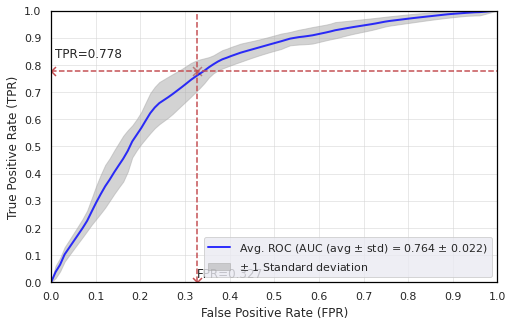


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.764 +/- 0.022
Accuracy (Avg. +/- Std.) is  0.725 +/- 0.019
Avg. CM is [[78, 33], [22, 67]]
Total for all folds CM is [[392, 165], [112, 339]]


In [333]:
clf_DT(X_Data, Y_Lavel, 'BloodPressure')

#### Analyzing **Random Forest**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       101
         1.0       0.82      0.86      0.84       101

    accuracy                           0.84       202
   macro avg       0.84      0.84      0.84       202
weighted avg       0.84      0.84      0.84       202


Area Under ROC (AUC): 0.916282717380649

Confusion Matrix for current fold: 
[[82 19]
 [14 87]]

Accuracy for Current Fold: 0.8366336633663366

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85       101
         1.0       0.83      0.88      0.86       101

    accuracy                           0.85       202
   macro avg       0.85      0.85      0.85       202
weighted avg       0.85      0.85      0.85       202


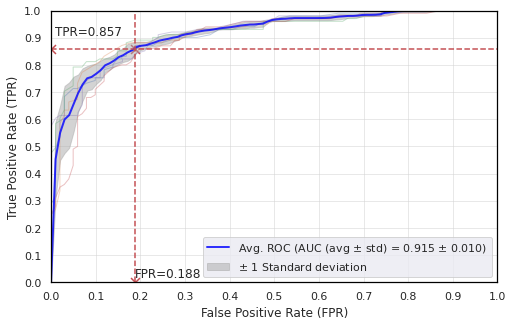


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.915 +/- 0.010
Accuracy (Avg. +/- Std.) is  0.834 +/- 0.014
Avg. CM is [[86, 19], [14, 81]]
Total for all folds CM is [[432, 95], [72, 409]]


In [334]:
clf_RF(X_Data, Y_Lavel, 'BloodPressure')

#### Analyzing **AdaBoost**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.76      0.67      0.72       101
         1.0       0.71      0.79      0.75       101

    accuracy                           0.73       202
   macro avg       0.74      0.73      0.73       202
weighted avg       0.74      0.73      0.73       202


Area Under ROC (AUC): 0.79462797764925

Confusion Matrix for current fold: 
[[68 33]
 [21 80]]

Accuracy for Current Fold: 0.7326732673267327

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74       101
         1.0       0.74      0.73      0.74       101

    accuracy                           0.74       202
   macro avg       0.74      0.74      0.74       202
weighted avg       0.74      0.74      0.74       202



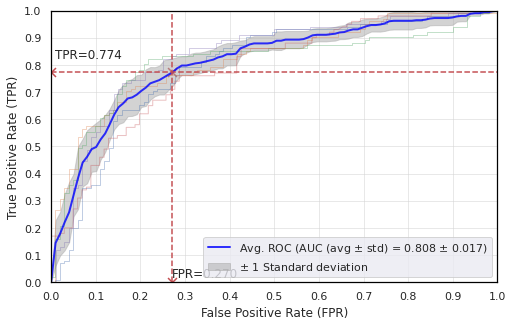


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.808 +/- 0.017
Accuracy (Avg. +/- Std.) is  0.752 +/- 0.025
Avg. CM is [[78, 27], [22, 73]]
Total for all folds CM is [[390, 136], [114, 368]]


In [335]:
clf_AB(X_Data, Y_Lavel, 'BloodPressure')

#### Analyzing **Naive Bayes**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.65      0.70      0.67       101
         1.0       0.67      0.61      0.64       101

    accuracy                           0.66       202
   macro avg       0.66      0.66      0.66       202
weighted avg       0.66      0.66      0.66       202


Area Under ROC (AUC): 0.7205175963140869

Confusion Matrix for current fold: 
[[71 30]
 [39 62]]

Accuracy for Current Fold: 0.6584158415841584

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.65      0.62      0.64       101
         1.0       0.64      0.66      0.65       101

    accuracy                           0.64       202
   macro avg       0.64      0.64      0.64       202
weighted avg       0.64      0.64      0.64       202

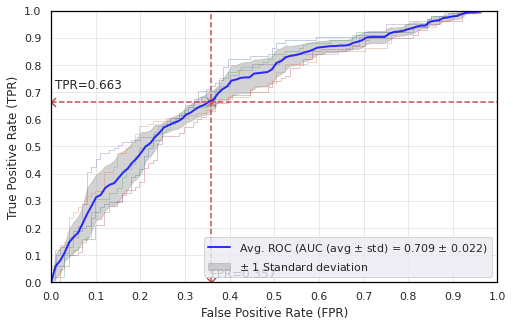


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.709 +/- 0.022
Accuracy (Avg. +/- Std.) is  0.653 +/- 0.013
Avg. CM is [[66, 36], [34, 64]]
Total for all folds CM is [[334, 180], [170, 324]]


In [336]:
clf_NB(X_Data, Y_Lavel, 'BloodPressure')

#### Analyzing **XGBoost**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81       101
         1.0       0.80      0.83      0.82       101

    accuracy                           0.81       202
   macro avg       0.81      0.81      0.81       202
weighted avg       0.81      0.81      0.81       202


Area Under ROC (AUC): 0.90226448387413

Confusion Matrix for current fold: 
[[80 21]
 [17 84]]

Accuracy for Current Fold: 0.8118811881188119

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       101
         1.0       0.81      0.79      0.80       101

    accuracy                           0.80       202
   macro avg       0.80      0.80      0.80       202
weighted avg       0.80      0.80      0.80       202



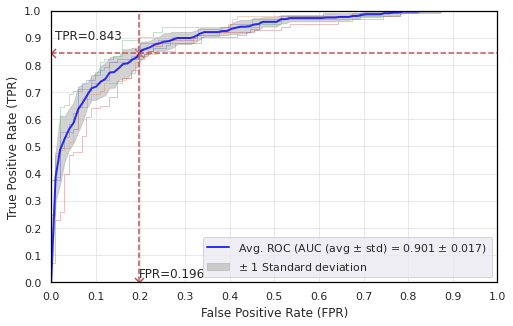


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.901 +/- 0.017
Accuracy (Avg. +/- Std.) is  0.823 +/- 0.019
Avg. CM is [[85, 19], [15, 81]]
Total for all folds CM is [[425, 99], [79, 405]]
Sensitivity (Avg. +/- Std.) is  0.843 +/- 0.032
Specificity (Avg. +/- Std.) is  0.804 +/- 0.022
Precision (Avg. +/- Std.) is  0.811 +/- 0.018
FOR (Avg. +/- Std.) is  0.162 +/- 0.027
DOR (Avg. +/- Std.) is  23.504 +/- 7.029


In [337]:
clf_XGB(X_Data, Y_Lavel, 'BloodPressure')

# With Glucose as Target

In [338]:
def categorize_GL(data_GL):
    #Oral glucose tolerance test
    GL = "Glucose"
    try:
        norm_i = data_GL.loc[(data_GL[GL] <= 140)] # normal
        #elevated_i = data_GL.loc[(data_GL[GL] > 140) & (data_GL[GL] < 200)] #prediabetic
        high_i =  data_GL.loc[data_GL[GL] > 140] #risk

        data_GL[GL][norm_i.index] = 0
        #data_GL[GL][elevated_i.index] = 2
        data_GL[GL][high_i.index] = 1
     
    except:
        pass
    
    return data_GL

In [339]:
data_GL = swap_col('Glucose')
print(data_GL.head()), data_GL.shape

   Pregnancies  Diabetic  ...   Age  Glucose
0          6.0         1  ...  50.0    148.0
1          1.0         0  ...  31.0     85.0
2          8.0         1  ...  32.0    183.0
3          1.0         0  ...  21.0     89.0
4          5.0         0  ...  30.0    116.0

[5 rows x 9 columns]


(None, (636, 9))

In [340]:
data_GL = categorize_GL(data_GL)

In [341]:
#Augmentation
smote = SMOTE()
X = np.array(data_GL.iloc[:,0:8])
y = np.array(data_GL.iloc[:,8])
X, y = smote.fit_resample(X, y)
data_GL = pd.DataFrame(X)
data_GL['Glucose'] = y
data_GL

,0,1,2,3,4,5,6,7,Glucose
0,6.000000,1.000000,72.000000,35.000000,171.474227,33.600000,0.627000,50.000000,1.0
1,1.000000,0.000000,66.000000,29.000000,113.606695,26.600000,0.351000,31.000000,0.0
2,8.000000,1.000000,64.000000,32.059259,171.474227,23.300000,0.672000,32.000000,1.0
3,1.000000,0.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0.0
4,5.000000,0.000000,74.000000,27.094512,113.606695,25.600000,0.201000,30.000000,0.0
...,...,...,...,...,...,...,...,...,...
993,1.354848,0.000000,61.064545,26.722895,113.606695,27.235515,0.192662,22.000000,1.0
994,3.494414,0.000000,75.011173,27.094512,113.606695,24.263131,0.225293,38.483241,1.0
995,6.099175,1.000000,66.198350,36.297524,313.458664,34.772318,0.402186,35.595049,1.0
996,3.909069,0.000000,72.363724,28.826732,124.873065,30.363411,0.326088,37.000000,1.0


In [342]:
data_GL.Glucose.value_counts()

0.0    499
1.0    499
Name: Glucose, dtype: int64

In [343]:
data_GL.columns = ['F' + str(i) for i in range(1,9)]+['Outcome'] #Renaming

In [344]:
X_Data,Y_Lavel = feature_Selector(data_GL, algo='None', n_feature=8)  

#### Analyzing **KNN**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78       100
         1.0       0.75      0.92      0.83       100

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.80       200
weighted avg       0.82      0.81      0.80       200


Area Under ROC (AUC): 0.8049999999999999

Confusion Matrix for current fold: 
[[69 31]
 [ 8 92]]

Accuracy for Current Fold: 0.805

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       100
         1.0       0.79      0.91      0.85       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200


Area Under

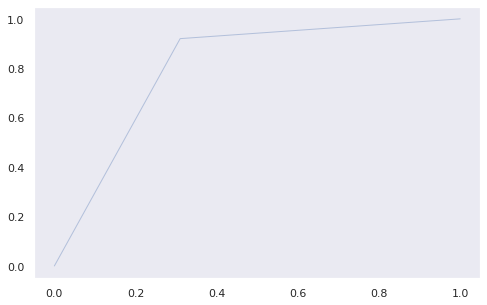

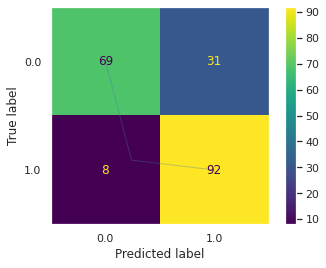

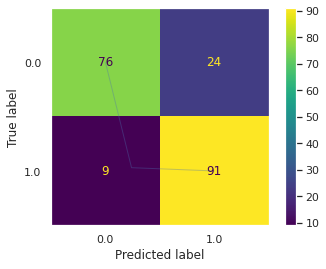

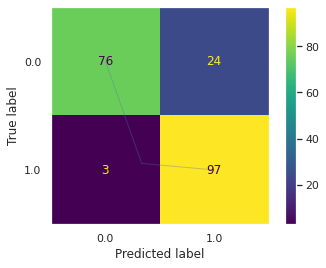

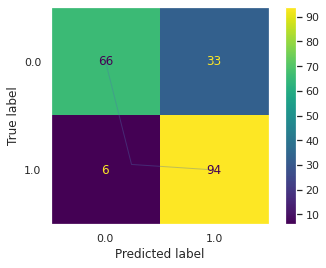

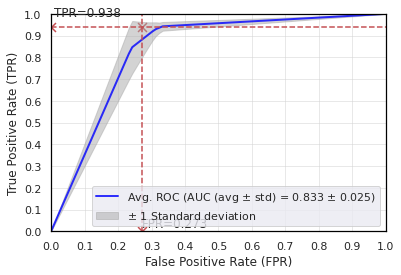


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.833 +/- 0.025
Accuracy (Avg. +/- Std.) is  0.833 +/- 0.025
Avg. CM is [[93, 27], [6, 72]]
Total for all folds CM is [[468, 136], [31, 363]]


In [345]:
clf_KNN(X_Data, Y_Lavel, 'Glucose')

In [346]:
#clf_KNN(X_Data, Y_Lavel, 'Glucose')

In [347]:
all_clf_res['BloodPressure']

['0.814+/-0.041',
 '0.764+/-0.022',
 '0.915+/-0.01',
 '0.808+/-0.017',
 '0.709+/-0.022',
 '0.901+/-0.017']

#### Analyzing **Decision Trees**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       100
         1.0       0.76      0.84      0.80       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200


Area Under ROC (AUC): 0.8084

Confusion Matrix for current fold: 
[[74 26]
 [16 84]]

Accuracy for Current Fold: 0.79

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       100
         1.0       0.76      0.78      0.77       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200


Area Under ROC (AUC): 0

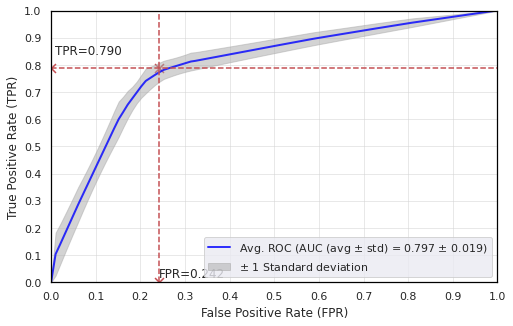


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.797 +/- 0.019
Accuracy (Avg. +/- Std.) is  0.774 +/- 0.009
Avg. CM is [[78, 24], [21, 75]]
Total for all folds CM is [[394, 121], [105, 378]]


In [348]:
clf_DT(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **Random Forest**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86       100
         1.0       0.85      0.89      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200


Area Under ROC (AUC): 0.94595

Confusion Matrix for current fold: 
[[84 16]
 [11 89]]

Accuracy for Current Fold: 0.865

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       100
         1.0       0.82      0.83      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200


Area Under ROC (AUC):

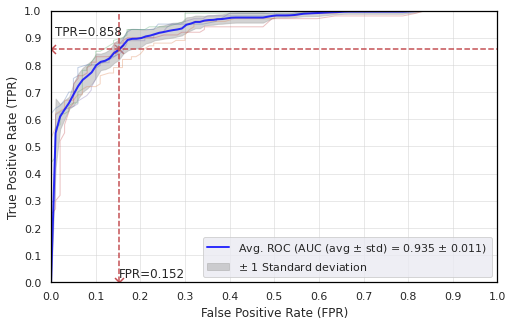


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.935 +/- 0.011
Accuracy (Avg. +/- Std.) is  0.853 +/- 0.016
Avg. CM is [[85, 15], [14, 84]]
Total for all folds CM is [[428, 76], [71, 423]]


In [349]:
clf_RF(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **AdaBoost**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       100
         1.0       0.84      0.81      0.82       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200


Area Under ROC (AUC): 0.8916999999999999

Confusion Matrix for current fold: 
[[84 16]
 [19 81]]

Accuracy for Current Fold: 0.825

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       100
         1.0       0.76      0.78      0.77       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200


Area Under

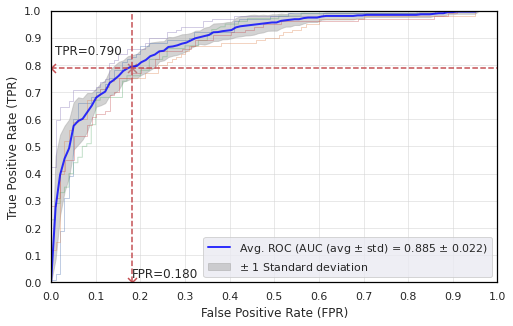


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.885 +/- 0.022
Accuracy (Avg. +/- Std.) is  0.805 +/- 0.026
Avg. CM is [[78, 18], [21, 81]]
Total for all folds CM is [[394, 90], [105, 409]]


In [350]:
clf_AB(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **Naive Bayes**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75       100
         1.0       0.74      0.82      0.78       100

    accuracy                           0.77       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.77      0.76       200


Area Under ROC (AUC): 0.8300000000000001

Confusion Matrix for current fold: 
[[71 29]
 [18 82]]

Accuracy for Current Fold: 0.765

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75       100
         1.0       0.75      0.73      0.74       100

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200


Area Under

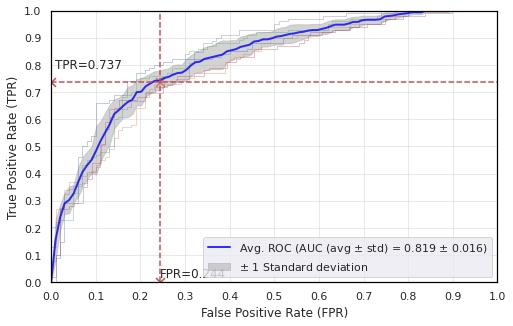


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.819 +/- 0.016
Accuracy (Avg. +/- Std.) is  0.746 +/- 0.013
Avg. CM is [[73, 24], [26, 75]]
Total for all folds CM is [[368, 122], [131, 377]]


In [351]:
clf_NB(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **XGBoost**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       100
         1.0       0.85      0.88      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200


Area Under ROC (AUC): 0.9372

Confusion Matrix for current fold: 
[[85 15]
 [12 88]]

Accuracy for Current Fold: 0.865

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       100
         1.0       0.83      0.81      0.82       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200


Area Under ROC (AUC): 

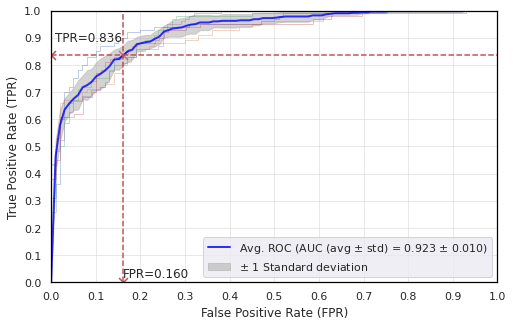


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.923 +/- 0.010
Accuracy (Avg. +/- Std.) is  0.838 +/- 0.016
Avg. CM is [[83, 16], [16, 83]]
Total for all folds CM is [[417, 80], [82, 419]]
Sensitivity (Avg. +/- Std.) is  0.836 +/- 0.029
Specificity (Avg. +/- Std.) is  0.840 +/- 0.013
Precision (Avg. +/- Std.) is  0.839 +/- 0.012
FOR (Avg. +/- Std.) is  0.163 +/- 0.024
DOR (Avg. +/- Std.) is  28.032 +/- 7.452


In [352]:
clf_XGB(X_Data, Y_Lavel, 'Glucose')

# Results

In [353]:
row_index = ['BloodPressure', 'Glucose']
model_names = ['KNN', 'DecisionTree', 'RandomForest', 'AdaBoost', 'NaiveBayes', 'XGBoost']
results = pd.DataFrame(all_clf_res['BloodPressure'], index = model_names)
results['Glucose'] = all_clf_res['Glucose']
results = results.transpose()

In [354]:
results.index = row_index

In [355]:
print("Binary clf with Augmentation")
results

Binary clf with Augmentation


,KNN,DecisionTree,RandomForest,AdaBoost,NaiveBayes,XGBoost
BloodPressure,0.814+/-0.041,0.764+/-0.022,0.915+/-0.01,0.808+/-0.017,0.709+/-0.022,0.901+/-0.017
Glucose,0.833+/-0.025,0.797+/-0.019,0.935+/-0.011,0.885+/-0.022,0.819+/-0.016,0.923+/-0.01
